# TC1- CLASIFICACION DE TEXTO CON LOGICA DIFUSA
## Implementación de un Analizador de Sentimientos

#### Integrantes del Grupo Nº2
| NOMBRES Y APELLIDOS | CODIGO |ROL|
|:----------|----------|:----------|
| Ambrosio Quispe, Jose Enrique| 19200181 | Integrante|
| Ortiz Abanto, Kevin Miguel| 20200230 | Integrante|
| Pachas Lopez, Nabia Jazmin| 20200231 | Integrante| 
| Retuerto Santillan, Mauro Alejandro| 20200202 | Coordinador|

## PREREQUISITOS
### Librerias requeridas

In [ ]:
%pip install emoji==1.7
%pip install spacy
%python -m spacy download es_core_news_sm
%pip install NRCLex
%pip install googletrans==4.0.0rc1

### Importación de Librerías

In [1]:
import re
import emoji
import spacy
import string
import numpy
import spacy
import nltk
import copy
import math
from nrclex import NRCLex
from googletrans import Translator

translator = Translator()
nlp = spacy.load("es_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nabia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Variables sobre emociones

In [2]:
emociones = {
   "fear":         ["😨","miedo",0],
   "anger":        ["😡", "enojo",1],
   "anticipation": ["🧐", "Anticipacion",2],
   "anticip":      ["🧐", "Anticipacion",2],
   "trust":        ["😉", "Confianza",3],
   "surprise":     ["😮", "Sorpresa",4],
   "positive":     ["➕", "Positivo",5],
   "negative":     ["➖", "Negativo",6],
   "sadness":      ["🥺", "Tristeza",7],
   "disgust":      ["🤢", "Asco",8],
   "joy":          ["😁", "Alegria",9]
}

In [3]:
opuestos = {
    "fear" : "trust",
    "anger" : "joy",
    "anticipation": "surprise",
    "anticip": "surprise",
    "trust" : "fear",
    "surprise": "anticipation",
    "positive": "negative",
    "negative": "positive",
    "sadness" : "joy",
    "disgust" : "joy",
    "joy":"sadness"
}
pronombres_ingles = {'I', 'you', 'he', 'she', 'it', 'we', 'they', 'myself', 'yourself', 'himself', 'herself', 'itself', 'ourselves', 'yourselves', 'themselves'}

In [4]:
nums_emociones = [
    "fear",
    "anger",
    "anticipation",
    "trust",
    "surprise",
    "positive",
    "negative",
    "sadness",
    "disgust",
    "joy"
]

### Variables sobre NPL
Consideramos negaciones, delimitadores y conectores

In [5]:
negadores = {"no", "tampoco", "nunca", "jamas", "jamás", "nadie", "nada", "ningun", "ningún",
              "ninguno", "ninguna"}

In [6]:
delimitadores = {",", ";", ":"}

In [7]:
conectores = {" y ", " o ", " cuando ", " u "," aunque ", " a pesar de "}

Consideramos conectores de contraste:
- **Intercambiables:** Ejm. "**Aunque** me haya ido, aun me importas"  = "Aun me importas, **aunque** me haya ido"
- **No Intercambiables:** Ejm. "Me fui **pero** aun me importas"
- **De negacion:** Ejm. "**No porque** me haya ido, significa que no me importas"

In [8]:
# Conectores de contraste con orden intercambiable
opositores_changeable = {"aunque", "a pesar de"} 

# Conectores de contraste no intercambiable
opositores_unchangeable = {"pero", "sin embargo", "no obstante", "por el contrario", "en cambio"}

# Conectores de contraste con negacion implicita
opositores_neg ={"no porque"}

Consideramos **intensificadores y atenuadores de adjetivos** para incrementar o atenuar el nivel de emocion que expresa un adjetivo en particular. Para modelar dicho comportamiento se utilizará la función raiz cuadrada para intensificadores y la funcion potencia para los atenuadores.
- **Ejm.** "Ella es extremadamente talentosa" , "Él es un poco exasperante"

In [9]:
# Intensificadores de adjetivos
intensificadores_adjetivos = {"extremadamente", "bastante", "realmente", "muy", "demasiado",
                              "increíblemente", "absolutamente", "sumamente", "completamente"}
# Atenuadores de adjetivos
atenuadores_adjetivos = {"poco"} # un poco

Consideramos **intensificadores y atenuadores de verbos** para incrementar o atenuar el nivel de emocion asociado a una accion. Para modelar dicho comportamiento se utilizará la función raiz cuadrada para intensificadores y la funcion potencia para los atenuadores.
- **Ejm.** "Ella baila bastante mal" , "Él cocina muy bien"

In [10]:
# intensifiers --> raiz cuadrada
intensificadores_accion = {"bien", "extremadamente bien", "bastante bien", "realmente bien",
                           "muy bien", "demasiado bien", "increíblemente bien", "absolutamente bien",
                           "sumamente bien", "completamente bien", 
                           "mucho", "muchisimo"
                          }

# attenuators --> potencia 2
atenuadores_accion = {"mal", "extremadamente mal", "bastante mal", "realmente mal", "muy mal",
                      "demasiado mal", "increíblemente mal", "absolutamente mal", "sumamente mal",
                      "completamente mal", "poco bien",
                      "poco" 
                     }

In [11]:
intensificadores_both = {"mejor", "mas"}
atenuadores_both = {"peor", "menos"}

### Modificacion de la lista de StopWords

In [12]:
no_pert_stopwords = {"bien","buen","buena","buenas","bueno","buenos","cierto","mal","verdadero","verdadera" }

Eliminamos de la lista de `stops words` de Spacy, aquellas palabras que usaremos para el procesamiento.

In [13]:
no_sw = no_pert_stopwords | negadores| intensificadores_adjetivos | atenuadores_adjetivos | intensificadores_accion |atenuadores_accion|intensificadores_both|atenuadores_both 

In [14]:
def modif_lista_stopwords(no_sw):
    for palabra in no_sw:   
        if palabra in nlp.Defaults.stop_words:        
            nlp.Defaults.stop_words.remove(palabra)

In [15]:
modif_lista_stopwords(no_sw)

## RECEPCIÓN DEL TWEET

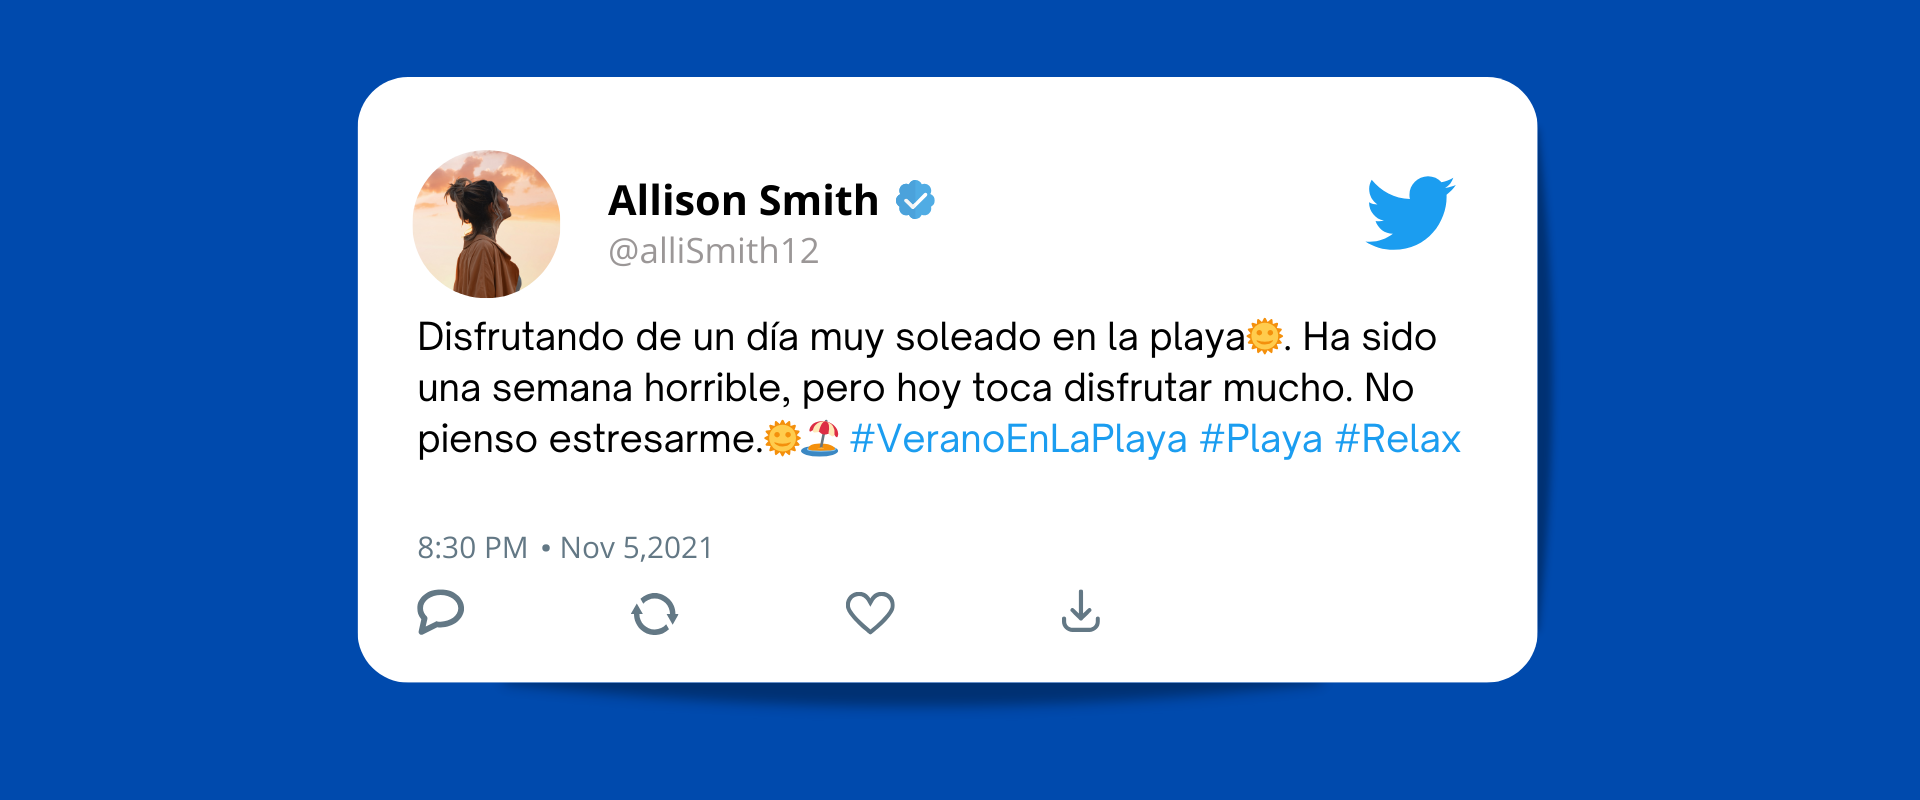

In [16]:
from IPython.display import Image
ruta_imagen = 'tweet_prueba.png' 
Image(filename=ruta_imagen)

In [17]:
tweet = "Disfrutando de un día muy soleado en la playa🌞. Ha sido una semana horrible, pero hoy toca disfrutar mucho. No pienso estresarme.🌞🏖️ #VeranoEnLaPlaya #Playa #Relax"

### División del Tweet

Para realizar el procesamiento, el tweet se dividirá en 3 grupos diferenciados:
1) Contenido
2) Hashtags
3) Emojis

In [18]:
def dividir_tweet(texto):
    # Encuentra y separa los emojis
    emojis = ''.join(c for c in texto if c in emoji.UNICODE_EMOJI['en'])
    
    # Elimina los emojis del texto original
    texto_sn = ''.join(c for c in texto if c not in emoji.UNICODE_EMOJI['en'])
    
    # Encuentra y separa los hashtags
    hashtags = ' '.join(re.findall(r'#\w+', texto_sn))
    
    # Elimina los hashtags del texto original
    contenido = re.sub(r'#\w+', '', texto_sn).strip()
    
    return contenido, hashtags, emojis

In [19]:
contenido_total, hashtags, emojis = dividir_tweet(tweet)
length = len(contenido_total)
print("-Contenido:", contenido_total)
print("-Hashtags:", hashtags)
print("-Emojis:", emojis)
print("-Longitud del tweet:", length)

-Contenido: Disfrutando de un día muy soleado en la playa. Ha sido una semana horrible, pero hoy toca disfrutar mucho. No pienso estresarme.️
-Hashtags: #VeranoEnLaPlaya #Playa #Relax
-Emojis: 🌞🌞🏖
-Longitud del tweet: 129


## PREPROCESAMIENTO DEL TWEET
## 1. Preprocesamiento del contenido

Esta etapa cuenta con las siguientes fases:
- División por oraciones
- Eliminación de URLS y Menciones
- Eliminación de Signos de Puntuación
- Conversión de Mayúsculas a Minúsculas
- Tokenización
- Eliminación de Palabras Vacías (Stop Words)
- Lematización
- Identificación de Conectores de Contraste y Negaciones
- Asignación de Valores
- Intensificación de Apartados
- Condensación de Contenido

### Division por oraciones

In [20]:
contenido_array = nltk.sent_tokenize(contenido_total)

In [21]:
contenido_array

['Disfrutando de un día muy soleado en la playa.',
 'Ha sido una semana horrible, pero hoy toca disfrutar mucho.',
 'No pienso estresarme.️']

Inicializamos los pesos de las oraciones

In [22]:
def init_pesos_oraciones(contenido_array):
    pesos_oraciones = []
    for i in range(len(contenido_array)):
        pesos_oraciones.append(1)
    return pesos_oraciones.copy()

In [23]:
pesos_oraciones = init_pesos_oraciones(contenido_array)

#### Eliminación de URLS y Menciones

In [24]:
def imprimir(txt_array):
    for i in range(len(txt_array)):
        print(i,":", txt_array[i])

In [25]:
def eliminar_urls_menc(array_oraciones):
    contenido_array = copy.deepcopy(array_oraciones)
    
    for i in range(len(contenido_array)):
        # Elimina los URL's
        contenido_array[i] = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', contenido_array[i])

        # Elimina las menciones
        contenido_array[i] = re.sub('@[^\s]+','', contenido_array[i])

        # Elimina los caracteres especiales
        contenido_array[i] = re.sub('[\s]+', ' ', contenido_array[i])
    
    contenido_array = [sublista for sublista in contenido_array if sublista]
    return contenido_array

In [26]:
contenido_array = eliminar_urls_menc(contenido_array)
imprimir(contenido_array)

0 : Disfrutando de un día muy soleado en la playa.
1 : Ha sido una semana horrible, pero hoy toca disfrutar mucho.
2 : No pienso estresarme.️


#### Conversión de Mayúsculas a Minúsculas
Esta técnica se utiliza para conseguir una mayor simplicidad en el texto

In [27]:
def to_lower(contenido_array):
    for i in range(len(contenido_array)):
        contenido_array[i] = contenido_array[i].lower()
    return contenido_array

In [28]:
contenido_array = to_lower(contenido_array)
imprimir(contenido_array)

0 : disfrutando de un día muy soleado en la playa.
1 : ha sido una semana horrible, pero hoy toca disfrutar mucho.
2 : no pienso estresarme.️


#### Subdivision por delimitadores y conectores
Esta técnica se utiliza para conseguir que las oraciones sean oraciones simples

Establecemos la funcion `is_division_correcta()` para verificar que se haya dividido la oracion en dos suboraciones que tengan al menos 3 palabras.

In [29]:
def is_division_correcta(suboraciones):
    division_correcta = True
    
    for j in range(len(suboraciones)):
        
        # Contamos la cantidad de palabras
        palabras = suboraciones[j].split()
        
        if(len(palabras) < 3):
            division_correcta = False
            break
            
    return division_correcta

Establecemos la funcion `get_suboraciones()` para obtener todas las suboraciones generadas a partir de un dividor(delimitador) específico.

In [30]:
def get_suboraciones(oracion, delimitador):
    # Dividmos la oracion segun el limitador actual
    suboraciones = oracion.split(delimitador)

    # Hubo subdivision ?
    if len(suboraciones) > 1:
        # Si hubo subdivision
        division_correcta = is_division_correcta(copy.deepcopy(suboraciones))
    
        if(division_correcta):
            return suboraciones
        else:
            return [oracion]
    else:
        # No hubo subdivision
        return suboraciones

Establecemos la funcion `modificar_pesos()` para modificar el peso o importancia de una oracion en funcion del delimitador `d` pasado como parámetro. Dicha modificación se realiza cuando se encuentra un conector de contraste intercambiable.

In [31]:
def modificar_pesos(suboraciones,pesos_suboraciones, d):
    # El delimitador es una coma ?
    if d==",":    
        for i in range(len(suboraciones)):
            for opositor in opositores_changeable:
                if suboraciones[i].startswith(opositor):
                    if i == 0:
                        pesos_suboraciones[i] = 0.3
                        pesos_suboraciones[i+1] = 1
                    else:
                        pesos_suboraciones[i] = 0.3
                        pesos_suboraciones[i-1] = 1
    
    # El delimitador es un conector de contraste intercambiable                    
    if d.strip() in opositores_changeable:
                    for i in range(len(suboraciones)):
                        if i == 0:
                            pesos_suboraciones[i] = 1
                        else: 
                            pesos_suboraciones[i] = 0.3
    return pesos_suboraciones

Establecemos la funcion `subdividir()` para subdividir varias oraciones compuestas en oraciones simples.

In [32]:
def subdividir(delimitadores, contenido_array,pesos_oraciones):
    nueva_lista = []
    nuevos_pesos_oraciones = []

    for delimitador in delimitadores:
        for i in range(len(contenido_array)):
            contenido_array[i] = contenido_array[i].strip()
            suboraciones = get_suboraciones(contenido_array[i], delimitador)

            for i in range(len(suboraciones)):
                suboraciones[i] = suboraciones[i].strip()

            nueva_lista.extend(suboraciones)


            if len(suboraciones) > 1:
                pesos_suboraciones = []

                for i in range(len(suboraciones)):
                        pesos_suboraciones.append(1)

                pesos_suboraciones = modificar_pesos(suboraciones,pesos_suboraciones, delimitador)

                nuevos_pesos_oraciones.extend(pesos_suboraciones)
            else:
                nuevos_pesos_oraciones.append(1)


        contenido_array = []
        contenido_array = nueva_lista.copy()
        nueva_lista = []

        pesos_oraciones = []
        pesos_oraciones = nuevos_pesos_oraciones.copy()
        nuevos_pesos_oraciones = []
    return contenido_array,pesos_oraciones

In [33]:
contenido_array, pesos_oraciones = subdividir(delimitadores,contenido_array,pesos_oraciones)
contenido_array, pesos_oraciones = subdividir(conectores,contenido_array,pesos_oraciones)

#### Eliminación de Signos de Puntuación

In [34]:
def eliminiar_punt(contenido_array):
    for i in range(len(contenido_array)):
    
        # Elimina los signos de puntuación
        signos_puntuacion =   string.punctuation+'¿¡'

        contenido_array[i] = [char for char in contenido_array[i] if char not in signos_puntuacion]

        contenido_array[i] = ''.join(contenido_array[i])
        

    return contenido_array

In [35]:
contenido_array = eliminiar_punt(contenido_array)
imprimir(contenido_array)

0 : disfrutando de un día muy soleado en la playa
1 : ha sido una semana horrible
2 : pero hoy toca disfrutar mucho
3 : no pienso estresarme️


#### Identificación de Conectores de Contraste
Procesamos los conectores de contraste

In [36]:
def procesar_opositores(contenido_array, pesos_oraciones):
    # opositores unchangeable
    for i in range(len(contenido_array)):
        for opositor in opositores_unchangeable:
            if opositor in contenido_array[i]:
                if i != 0:
                    pesos_oraciones[i-1] = 0.3

    # opositores negacion
    for i in range(len(contenido_array)-1):
        for opositor in opositores_neg:
            if opositor in contenido_array[i]:
                    pesos_oraciones[i] = 0.3
                    pesos_oraciones[i+1] = 1  
                    
    return contenido_array, pesos_oraciones

In [37]:
contenido_array, pesos_oraciones = procesar_opositores(contenido_array, pesos_oraciones)

Los pesos se modifican a:

In [38]:
pesos_oraciones

[1, 0.3, 1, 1]

#### Tokenización

Proceso básico que disemina las oraciones en palabras, para este se hará uso de SpaCy

In [39]:
def tokenizar_texto(texto):
    doc = nlp(texto)
    tokens = [token.text for token in doc]
    return tokens

In [40]:
def tokenizar_tweet(contenido_array):
    tokens_array = []
    for i in range(len(contenido_array)):

        tokens_contenido = tokenizar_texto(contenido_array[i])
        tokens_array.append(tokens_contenido)

    return tokens_array

In [41]:
tokens_array = tokenizar_tweet(contenido_array)

In [42]:
imprimir(tokens_array)

0 : ['disfrutando', 'de', 'un', 'día', 'muy', 'soleado', 'en', 'la', 'playa']
1 : ['ha', 'sido', 'una', 'semana', 'horrible']
2 : ['pero', 'hoy', 'toca', 'disfrutar', 'mucho']
3 : ['no', 'pienso', 'estresarme️']


#### Eliminación de Palabras Vacías (Stop Words)

Estas palabras como pueden ser “de”, “el” o “una” son palabras que aparecen con mayor frecuencia y no aportan un significado semántico específico

In [43]:
def no_stopwords(tokens_list):
    hay_stopwords_izq = []
    hay_stopwords_der = []
    tokens_limpios = []
    
    cont = 0
    izq_pendiente = False
    for i in range(len(tokens_list)):
 
        if tokens_list[i] not in nlp.Defaults.stop_words:
            if(izq_pendiente):
                hay_stopwords_izq.append(1)
                izq_pendiente = False
            else:
                hay_stopwords_izq.append(0)
            hay_stopwords_der.append(0)
            tokens_limpios.append(tokens_list[i])
            cont = cont + 1
        else:
            if(cont!=0):
                hay_stopwords_der[cont - 1] = 1 
            izq_pendiente = True
        
    #tokens_limpios = [token for token in tokens_list if token not in nlp.Defaults.stop_words]
    
    return tokens_limpios,hay_stopwords_izq,hay_stopwords_der

In [44]:
def eliminar_stopwords(tokens_array):
    swd = []
    swi = []
    for i in range(len(tokens_array)):
        tokens_array[i],izq, der = no_stopwords(tokens_array[i])
        swi.append(izq.copy())
        swd.append(der.copy())
    
    return tokens_array,swi,swd

In [45]:
tokens_array,swi,swd = eliminar_stopwords(tokens_array)

In [46]:
imprimir(tokens_array)

0 : ['disfrutando', 'muy', 'soleado', 'playa']
1 : ['semana', 'horrible']
2 : ['toca', 'disfrutar', 'mucho']
3 : ['no', 'pienso', 'estresarme️']


In [47]:
swi

[[0, 1, 0, 1], [1, 0], [1, 0, 0], [0, 0, 0]]

In [48]:
swd

[[1, 0, 1, 0], [0, 0], [0, 0, 0], [0, 0, 0]]

#### Traduccion
Traducimos los lemmas extraidos para poder hacer uso de la libreria NRCLex.

In [52]:
def to_english(tokens_array):
    tokens_array_en = copy.deepcopy(tokens_array)
    
    for i in range(len(tokens_array_en)):
        for j in range(len(tokens_array_en[i])):
            tmp = translator.translate(tokens_array_en[i][j], src='es', dest='en')
            tokens_array_en[i][j] = tmp.text
    
    return tokens_array_en

In [53]:
tokens_array_en = to_english(tokens_array)

In [54]:
imprimir(tokens_array_en)

0 : ['Enjoying', 'very', 'sunny', 'beach']
1 : ['week', 'awful']
2 : ['touches', 'enjoy', 'a lot']
3 : ['No', 'I think', 'Stress me']


#### Lematización

Esta técnica sirve para reducir variantes morfológicas de la formas de una palabra a raíces comunes o lexemas

In [55]:
def lematizar_adverbios(oraciones):
    for k in range(len(oraciones)):
        for i in range(len(oraciones[k])):
            if  len(oraciones[k][i])>2 and oraciones[k][i].endswith("ly") and oraciones[k][i] not in intensificadores_adjetivos:
                oraciones[k][i] = oraciones[k][i][:-len("ly")]
    return oraciones

In [56]:
def lematizar_oracion(tokens_list):
    lema = [token.lemma_ for token in nlp_en(" ".join(tokens_list))]
    return lema

In [57]:
def lematizar(tokens_array_en):
    for i in range(len(tokens_array_en)):
        tokens_array_en[i] = lematizar_oracion(tokens_array_en[i])
    
    return tokens_array_en

In [58]:
tokens_array_en = lematizar_adverbios(tokens_array_en)
tokens_array_en = lematizar(tokens_array_en)

In [59]:
imprimir(tokens_array_en)

0 : ['enjoy', 'very', 'sunny', 'beach']
1 : ['week', 'awful']
2 : ['touch', 'enjoy', 'a', 'lot']
3 : ['no', 'I', 'think', 'stress', 'I']


In [60]:
tokens_array_en = [[palabra for palabra in sublista if palabra not in pronombres_ingles] for sublista in tokens_array_en]

In [61]:
tokens_array_en

[['enjoy', 'very', 'sunny', 'beach'],
 ['week', 'awful'],
 ['touch', 'enjoy', 'a', 'lot'],
 ['no', 'think', 'stress']]

#### Asignación de Valores
Asignamos un nivel de emocion a cada palabra utilizando la libreria NRCLex

In [62]:
def show_emociones(arrayt_nivel_emociones):
    txt = ""
    for tupla in arrayt_nivel_emociones:
        if(tupla[1]!=0.0):
            txt = txt + emociones[tupla[0]][0]+ "" + str(tupla[1]) + "," 
    return txt

In [63]:
def showall_emociones(tokens_array, niveles_emocion):
    
    for i in range(len(tokens_array)):
        for j in range(len(tokens_array[i])):
            print(tokens_array[i][j], ':', show_emociones(niveles_emocion[i][j]))

In [64]:
def corregir_niveles(array):
    for i in range(len(array)):
        array[i] = [array[i][0], pow(array[i][1],1/2.5)]
    return array

In [65]:
def get_niveles_emocion(tokens_array_en):
    niveles_emocion = copy.deepcopy(tokens_array_en)

    for i in range(len(tokens_array_en)):
        for j in range(len(tokens_array_en[i])):
            array_tuplas = NRCLex(tokens_array_en[i][j].lower()).top_emotions
            niveles_emocion[i][j] = [list(tupla) for tupla in array_tuplas]
            niveles_emocion[i][j] = corregir_niveles(niveles_emocion[i][j])
   
    return niveles_emocion

In [66]:
niveles_emocion = get_niveles_emocion(tokens_array_en)

In [67]:
showall_emociones(tokens_array, niveles_emocion)

disfrutando : 😉0.5743491774985174,➕0.5743491774985174,😁0.5743491774985174,🧐0.5743491774985174,
muy : 
soleado : 😮0.5743491774985174,➕0.5743491774985174,😁0.5743491774985174,🧐0.5743491774985174,
playa : 😁1.0,
semana : 
horrible : 😨0.5253055608807534,😡0.5253055608807534,➖0.5253055608807534,🥺0.5253055608807534,🤢0.5253055608807534,
toca : 
disfrutar : 😉0.5743491774985174,➕0.5743491774985174,😁0.5743491774985174,🧐0.5743491774985174,
mucho : 
no : 
pienso : 
estresarme️ : ➖1.0,


#### Procesamiento de intensificadores y atenuadores

Definimos la funcion `actualizar_nivel_emociones()` que permite intensificar o atenuar los niveles de emociones de cada lemma del tweet.

In [68]:
def actualizar_nivel_emociones(niveles_emocion,tipo_operacion): #Parametro es una lista de tuplas
    nuevos_niveles_emocion = []
    
    for i in range(len(niveles_emocion)):
        sub_lista = [niveles_emocion[i][0], 0.0]
        if(tipo_operacion == 0): # raiz cuadrada, intensificar
            sub_lista[1] = math.sqrt(niveles_emocion[i][1])
        else: # potencia 2, atenuar
            sub_lista[1] = niveles_emocion[i][1] ** 2
            
        nuevos_niveles_emocion.append(sub_lista)
    return nuevos_niveles_emocion

Definimos la funcion `procesar_adjetivos()` que permite intensificar o atenuar los adjetivos del tweet.

In [69]:
def procesar_adjetivos(tokens_array, niveles_emocion):
    
    # Intensificar y atenuar adjetivos
    for i in range(len(tokens_array)):
        for j in range(len(tokens_array[i]) - 1):
            if tokens_array[i][j] in intensificadores_adjetivos:
                niveles_emocion[i][j + 1] = actualizar_nivel_emociones(niveles_emocion[i][j + 1], 0)

            if tokens_array[i][j] in atenuadores_adjetivos:
                niveles_emocion[i][j + 1] = actualizar_nivel_emociones(niveles_emocion[i][j + 1], 1)
    return niveles_emocion

Definimos la funcion `procesar_adjetivos()` que permite intensificar o atenuar los verbos del tweet.

In [70]:
def procesar_acciones(tokens_array, niveles_emocion):
    
    # Intensificar y atenuar acciones
    for i in range(len(tokens_array)):
        for j in range(len(tokens_array[i]) - 1):
            if(j < len(tokens_array[i]) - 3):
                modif1 = tokens_array[i][j + 1] + " " + tokens_array[i][j + 2]
            else:
                modif1 = ""
            modif2 = tokens_array[i][j + 1]


            if modif1 in intensificadores_accion or modif2 in intensificadores_accion:
                niveles_emocion[i][j] = actualizar_nivel_emociones(niveles_emocion[i][j], 0)

            if modif1 in atenuadores_accion or modif2 in atenuadores_accion:
                niveles_emocion[i][j] = actualizar_nivel_emociones(niveles_emocion[i][j], 1)
    return niveles_emocion

In [71]:
def procesar_otros(tokens_array, tokens_array_en, niveles_emocion, swi, swd):
    
    # Intensificar y atenuar adjetivos o acciones
    for i in range(len(tokens_array)):
        for j in range(len(tokens_array[i])):
            
            if tokens_array[i][j] in intensificadores_both:
                
                if(swi[i][j] != 1):
                    if((j - 1) > 0):
                        tipo = nlp_en(tokens_array_en[i][j - 1])
                        if(tipo[0].pos_ == 'VERB'):
                            niveles_emocion[i][j - 1] = actualizar_nivel_emociones(niveles_emocion[i][j - 1], 0)

                if(swd[i][j] != 1):
                    if((j + 1)< len(tokens_array[i])):
                        tipo = nlp_en(tokens_array_en[i][j + 1])
                        if(tipo[0].pos_ == 'NOUN'):
                            niveles_emocion[i][j + 1] = actualizar_nivel_emociones(niveles_emocion[i][j + 1], 0)

            if tokens_array[i][j] in atenuadores_both:
                if(swi[i][j] != 1):
                    if((j - 1) > 0):
                        tipo = nlp_en(tokens_array_en[i][j - 1])
                        if(tipo[0].pos_ == 'VERB'):
                            niveles_emocion[i][j - 1] = actualizar_nivel_emociones(niveles_emocion[i][j - 1], 1)

                if(swd[i][j] != 1):
                    if((j + 1)< len(tokens_array[i])):
                        tipo = nlp_en(tokens_array_en[i][j + 1])
                        if(tipo[0].pos_ == 'NOUN'):
                            niveles_emocion[i][j + 1] = actualizar_nivel_emociones(niveles_emocion[i][j + 1], 1)
    return niveles_emocion

In [72]:
niveles_emocion = procesar_adjetivos(tokens_array, niveles_emocion)

In [73]:
niveles_emocion = procesar_acciones(tokens_array, niveles_emocion)

In [74]:
niveles_emocion = procesar_otros(tokens_array, tokens_array_en, niveles_emocion, swi, swd)

In [75]:
showall_emociones(tokens_array, niveles_emocion)

disfrutando : 😉0.5743491774985174,➕0.5743491774985174,😁0.5743491774985174,🧐0.5743491774985174,
muy : 
soleado : 😮0.757858283255199,➕0.757858283255199,😁0.757858283255199,🧐0.757858283255199,
playa : 😁1.0,
semana : 
horrible : 😨0.5253055608807534,😡0.5253055608807534,➖0.5253055608807534,🥺0.5253055608807534,🤢0.5253055608807534,
toca : 
disfrutar : 😉0.757858283255199,➕0.757858283255199,😁0.757858283255199,🧐0.757858283255199,
mucho : 
no : 
pienso : 
estresarme️ : ➖1.0,


#### Procesamiento de negaciones

In [76]:
def is_vacio(array_niveles_emociones):
    
    for emocion_subarray in array_niveles_emociones:
        if(emocion_subarray[1] != 0.0):
            return False
    return True

In [77]:
def negar(array_niveles_emociones):
    array_tmp = copy.deepcopy(array_niveles_emociones)
    
    for i in range(len(array_niveles_emociones)):
        if array_niveles_emociones[i][1] != 0.0:
            nomb_emocion_actual = array_niveles_emociones[i][0]
            array_tmp[i][0] = opuestos[nomb_emocion_actual]
    return array_tmp

In [78]:
def aplicar_negaciones(tokens_array, niveles_emocion):

    for i in range(len(tokens_array)):
        for negac in negadores:
            for j in range(len(tokens_array[i])):
                if tokens_array[i][j] == negac:
                    encontrado = False
                    k = j + 1
                    while not encontrado and k <len(tokens_array[i]):

                        if not is_vacio(niveles_emocion[i][k]):
                            encontrado = True
                        else:
                            k = k + 1
                    if encontrado:
                        niveles_emocion[i][k] = negar(niveles_emocion[i][k])
    return niveles_emocion

In [79]:
niveles_emocion = aplicar_negaciones(tokens_array, niveles_emocion)

In [80]:
showall_emociones(tokens_array, niveles_emocion)

disfrutando : 😉0.5743491774985174,➕0.5743491774985174,😁0.5743491774985174,🧐0.5743491774985174,
muy : 
soleado : 😮0.757858283255199,➕0.757858283255199,😁0.757858283255199,🧐0.757858283255199,
playa : 😁1.0,
semana : 
horrible : 😨0.5253055608807534,😡0.5253055608807534,➖0.5253055608807534,🥺0.5253055608807534,🤢0.5253055608807534,
toca : 
disfrutar : 😉0.757858283255199,➕0.757858283255199,😁0.757858283255199,🧐0.757858283255199,
mucho : 
no : 
pienso : 
estresarme️ : ➕1.0,


#### Realizacion de Promedios

In [81]:
def to_array10(array_niveles_emociones):
    array10 = [0,0,0,0,0,0,0,0,0,0]
    for nivel in array_niveles_emociones:
        indice = emociones[nivel[0]][2]
        array10[indice] = nivel[1]
    return array10.copy()

In [82]:
def get_puntuaciones(tokens_array, niveles_emocion):
    puntuacion_oraciones = []
    for i in range(len(tokens_array)):
        puntuacion_oracion = []
        for j in range(len(tokens_array[i])):
            array_tmp = to_array10(niveles_emocion[i][j])
            puntuacion_oracion.append(array_tmp)
        puntuacion_oraciones.append(copy.deepcopy(puntuacion_oracion))
        
    return puntuacion_oraciones

In [83]:
def get_promedios(puntuacion_oraciones):
    proms_oraciones = []
    for i in range(len(puntuacion_oraciones)):
        prom_oracion = []
        for k in range(10):
            prom = 0.0
            for j in range(len(puntuacion_oraciones[i])):
                prom =max(prom,puntuacion_oraciones[i][j][k])
            prom_oracion.append(prom)
        proms_oraciones.append(prom_oracion)
        
    return proms_oraciones

In [84]:
def aplicar_pesos(proms_oraciones, pesos_oraciones):
    proms_oraciones_peso = copy.deepcopy(proms_oraciones)
    for i in range(len(proms_oraciones_peso)):
        for j in range(len(proms_oraciones_peso[i])):
            proms_oraciones_peso[i][j] = proms_oraciones_peso[i][j] * pesos_oraciones[i]
    return proms_oraciones_peso 

In [85]:
def get_puntuacion_tweet(proms_oraciones_peso):
    
    puntuacion_tweet = []
    i = 0
    for j in range(len(proms_oraciones_peso[i])):
        pnt_emocion = 0.0
        cont = 0.0
        prom = 0.0
        for i in range(len(proms_oraciones_peso)):
            if(proms_oraciones_peso[i][j] != 0.0):
                pnt_emocion = pnt_emocion + proms_oraciones_peso[i][j]
                cont = cont + 1
        if(cont != 0.0):
            prom = pnt_emocion/cont
        i = i + 1

        puntuacion_tweet.append(prom)
    return puntuacion_tweet

In [86]:
def imprimir_puntuacion(puntuaciones_tweet):
    for i in range(len(puntuaciones_tweet)):
        print(emociones[nums_emociones[i]]," : ",puntuaciones_tweet[i])

In [87]:
puntuacion_oraciones = get_puntuaciones(tokens_array, niveles_emocion)
proms_oraciones = get_promedios(puntuacion_oraciones)
proms_oraciones_peso  = aplicar_pesos(proms_oraciones,pesos_oraciones)
puntuacion_tweet = get_puntuacion_tweet(proms_oraciones_peso)

In [88]:
print("PUNTUACION CONTENIDO:")
imprimir_puntuacion(puntuacion_tweet)

PUNTUACION CONTENIDO:
['😨', 'miedo', 0]  :  0.15759166826422602
['😡', 'enojo', 1]  :  0.15759166826422602
['🧐', 'Anticipacion', 2]  :  0.757858283255199
['😉', 'Confianza', 3]  :  0.6661037303768582
['😮', 'Sorpresa', 4]  :  0.757858283255199
['➕', 'Positivo', 5]  :  0.8385721888367993
['➖', 'Negativo', 6]  :  0.15759166826422602
['🥺', 'Tristeza', 7]  :  0.15759166826422602
['🤢', 'Asco', 8]  :  0.15759166826422602
['😁', 'Alegria', 9]  :  0.8789291416275995


## 2. Preprocesamiento de Hashtags
#### Eliminación del '#'

In [89]:
hashtags = re.sub(r'#([^\s]+)', r'\1', hashtags)

In [90]:
print("Hashtags:", hashtags)

Hashtags: VeranoEnLaPlaya Playa Relax


#### Tokenización

In [91]:
hashtags = tokenizar_texto(hashtags)

In [92]:
print("Tokens de Hashtags:", hashtags)

Tokens de Hashtags: ['VeranoEnLaPlaya', 'Playa', 'Relax']


#### Separar palabras internas

In [93]:
def separar_palabras_en_hashtag(hashtag):
    # Utilizar expresiones regulares para separar palabras por mayúsculas o caracteres especiales
    palabras = re.findall(r'[A-Z][a-z]*', hashtag)
    
    return palabras


In [94]:
def separar_palabras(hashtags):
    for i in range(len(hashtags)):
        hashtags[i] = separar_palabras_en_hashtag(hashtags[i])
    return hashtags

In [95]:
hashtags = separar_palabras(hashtags)

In [96]:
imprimir(hashtags)

0 : ['Verano', 'En', 'La', 'Playa']
1 : ['Playa']
2 : ['Relax']


#### Conversión de Mayúsculas a Minúsculas

In [97]:
def hashtag_to_lower(hashtags):
    for i in range(len(hashtags)):
        for j in range(len(hashtags[i])):
            hashtags[i][j] = hashtags[i][j].lower()
    return hashtags

In [98]:
hashtags = hashtag_to_lower(hashtags)

In [99]:
imprimir(hashtags)

0 : ['verano', 'en', 'la', 'playa']
1 : ['playa']
2 : ['relax']


#### Traduccion

In [100]:
def hashtag_to_english(hashtags): 
    hashtags_en = copy.deepcopy(hashtags)
    
    for i in range(len(hashtags_en)):
        for j in range(len(hashtags_en[i])):
            tmp = translator.translate(hashtags_en[i][j], src='es', dest='en')
            hashtags_en[i][j] = tmp.text
    return hashtags_en

In [101]:
def lemmatize(tokens_list):
    lemma = [token.lemma_ for token in nlp_en(" ".join(tokens_list))]
    return lemma

In [102]:
def lemmatize_txt(tokens_array):
    for i in range(len(tokens_array)):
        tokens_array[i] = lemmatize(tokens_array[i])
    
    return tokens_array

In [103]:
hashtags_en = hashtag_to_english(hashtags)
hashtags_en = lemmatize_txt(hashtags_en)

In [104]:
imprimir(hashtags_en)

0 : ['summer', 'in', 'the', 'beach']
1 : ['beach']
2 : ['relax']


#### Asignación de Valores

In [105]:
niveles_emocion_hashtags = get_niveles_emocion(hashtags_en)

In [106]:
showall_emociones(hashtags, niveles_emocion_hashtags)

verano : 
en : 
la : 
playa : 😁1.0,
playa : 😁1.0,
relax : 


#### Calculo de Promedios

In [107]:
puntuacion_hashtags = get_puntuaciones(hashtags, niveles_emocion_hashtags)
proms_hashtags = get_promedios(puntuacion_hashtags)
puntuacion_hashtags_tweet = get_puntuacion_tweet(proms_hashtags)

In [108]:
imprimir_puntuacion(puntuacion_hashtags_tweet)

['😨', 'miedo', 0]  :  0.0
['😡', 'enojo', 1]  :  0.0
['🧐', 'Anticipacion', 2]  :  0.0
['😉', 'Confianza', 3]  :  0.0
['😮', 'Sorpresa', 4]  :  0.0
['➕', 'Positivo', 5]  :  0.0
['➖', 'Negativo', 6]  :  0.0
['🥺', 'Tristeza', 7]  :  0.0
['🤢', 'Asco', 8]  :  0.0
['😁', 'Alegria', 9]  :  1.0


## 3. Preprocesamiento de Emojis
#### Creación del Diccionario de Emojis

Creación del diccionario de sentimientos de emojis. Estos serán dependientes de las anteriores emociones, respectivamente.

In [109]:
#Creación del diccionario
         # miedo enojo anti confia sopre  posi nega triste asco alegria
dict_emojis = {
    "😊": [0.00, 0.00, 0.10, 0.75, 0.20, 0.85, 0.05, 0.00, 0.00, 0.95],
    "😂": [0.00, 0.00, 0.12, 0.68, 0.10, 0.87, 0.22, 0.00, 0.00, 0.96],
    "😹": [0.00, 0.00, 0.11, 0.68, 0.14, 0.85, 0.23, 0.03, 0.00, 0.96],
    "🙂": [0.15, 0.25, 0.55, 0.40, 0.63, 0.53, 0.18, 0.09, 0.20, 0.55],
    "🤣": [0.00, 0.00, 0.14, 0.68, 0.12, 0.84, 0.19, 0.00, 0.00, 0.99],
    "😄": [0.00, 0.00, 0.13, 0.80, 0.11, 0.86, 0.21, 0.00, 0.00, 0.98],
    "😆": [0.00, 0.00, 0.12, 0.70, 0.10, 0.88, 0.24, 0.00, 0.00, 0.99],
    "😅": [0.20, 0.00, 0.16, 0.40, 0.46, 0.69, 0.16, 0.10, 0.20, 0.55],
    "😎": [0.00, 0.00, 0.22, 0.98, 0.18, 0.90, 0.30, 0.10, 0.00, 0.96],
    "😇": [0.10, 0.00, 0.13, 0.80, 0.17, 0.91, 0.31, 0.00, 0.00, 0.88],
    "🤗": [0.00, 0.00, 0.14, 0.85, 0.16, 0.82, 0.32, 0.00, 0.00, 0.88],
    "🙃": [0.35, 0.40, 0.40, 0.20, 0.59, 0.59, 0.28, 0.10, 0.20, 0.55],
    "😕": [0.20, 0.45, 0.48, 0.20, 0.54, 0.16, 0.36, 0.20, 0.40, 0.45],
    "😔": [0.60, 0.16, 0.26, 0.10, 0.52, 0.18, 0.38, 0.42, 0.10, 0.05],
    "😢": [0.77, 0.15, 0.25, 0.20, 0.31, 0.09, 0.39, 0.53, 0.20, 0.05],
    "😥": [0.78, 0.14, 0.24, 0.20, 0.40, 0.10, 0.40, 0.54, 0.20, 0.05],
    "😟": [0.76, 0.22, 0.22, 0.20, 0.68, 0.12, 0.42, 0.56, 0.20, 0.05],
    "🙁": [0.75, 0.23, 0.23, 0.20, 0.49, 0.11, 0.41, 0.57, 0.40, 0.05],
    "😮": [0.31, 0.10, 0.47, 0.15, 0.80, 0.32, 0.34, 0.56, 0.10, 0.15],
    "😯": [0.42, 0.10, 0.48, 0.15, 0.71, 0.33, 0.35, 0.27, 0.10, 0.15],
    "😲": [0.49, 0.10, 0.45, 0.13, 0.78, 0.36, 0.32, 0.24, 0.20, 0.15],
    "😳": [0.48, 0.10, 0.44, 0.12, 0.77, 0.37, 0.33, 0.23, 0.30, 0.15],
    "😦": [0.55, 0.17, 0.41, 0.19, 0.65, 0.10, 0.36, 0.40, 0.20, 0.15],
    "😧": [0.66, 0.18, 0.42, 0.20, 0.76, 0.10, 0.35, 0.41, 0.25, 0.15],
    "😨": [0.95, 0.10, 0.49, 0.17, 0.82, 0.01, 0.37, 0.47, 0.40, 0.05],
    "😰": [0.98, 0.10, 0.32, 0.20, 0.76, 0.08, 0.39, 0.40, 0.40, 0.05],
    "😱": [0.87, 0.19, 0.41, 0.09, 0.95, 0.01, 0.38, 0.39, 0.25, 0.08],
    "😠": [0.60, 0.81, 0.53, 0.15, 0.30, 0.00, 0.37, 0.31, 0.20, 0.00],
    "😡": [0.62, 0.98, 0.55, 0.10, 0.30, 0.00, 0.35, 0.33, 0.20, 0.00],
    "😤": [0.43, 0.90, 0.56, 0.10, 0.20, 0.00, 0.34, 0.34, 0.20, 0.00],
    "😖": [0.97, 0.88, 0.30, 0.12, 0.40, 0.00, 0.30, 0.48, 0.80, 0.00],
    "😣": [0.85, 0.86, 0.38, 0.16, 0.40, 0.00, 0.32, 0.56, 0.70, 0.00],
    "😞": [0.88, 0.69, 0.31, 0.09, 0.35, 0.00, 0.29, 0.69, 0.66, 0.00],
    "😒": [0.36, 0.67, 0.39, 0.17, 0.23, 0.10, 0.31, 0.17, 0.60, 0.00],
    "😏": [0.49, 0.20, 0.42, 0.50, 0.16, 0.20, 0.28, 0.10, 0.20, 0.15],
    "🙄": [0.30, 0.35, 0.43, 0.25, 0.27, 0.06, 0.27, 0.21, 0.61, 0.15],
    "😣": [0.45, 0.46, 0.38, 0.16, 0.20, 0.00, 0.32, 0.56, 0.70, 0.00],
    "😢": [0.69, 0.30, 0.42, 0.20, 0.30, 0.10, 0.28, 0.60, 0.20, 0.00],
    "😭": [0.81, 0.12, 0.44, 0.12, 0.30, 0.00, 0.26, 0.89, 0.20, 0.00],
    "😪": [0.73, 0.24, 0.46, 0.34, 0.10, 0.00, 0.24, 0.70, 0.20, 0.10],
    "😴": [0.10, 0.00, 0.48, 0.50, 0.00, 0.40, 0.22, 0.00, 0.20, 0.50],
    "🤤": [0.00, 0.00, 0.49, 0.60, 0.10, 0.80, 0.21, 0.47, 0.20, 0.95],
    "😷": [0.58, 0.28, 0.50, 0.30, 0.34, 0.29, 0.20, 0.10, 0.20, 0.15],
    "🤒": [0.79, 0.33, 0.51, 0.20, 0.45, 0.00, 0.19, 0.79, 0.30, 0.05],
    "🤕": [0.71, 0.45, 0.52, 0.10, 0.56, 0.01, 0.18, 0.80, 0.20, 0.05],
    "🤢": [0.72, 0.42, 0.53, 0.15, 0.57, 0.02, 0.17, 0.61, 0.90, 0.05],
    "🤮": [0.73, 0.43, 0.54, 0.12, 0.58, 0.03, 0.16, 0.62, 0.95, 0.05],
    "🥴": [0.45, 0.25, 0.55, 0.30, 0.49, 0.24, 0.15, 0.43, 0.00, 0.15],
    "🥺": [0.67, 0.27, 0.56, 0.24, 0.30, 0.05, 0.14, 0.84, 0.00, 0.05],
    "🥱": [0.10, 0.10, 0.10, 0.35, 0.11, 0.46, 0.13, 0.15, 0.00, 0.45],
    "🤧": [0.70, 0.35, 0.58, 0.16, 0.12, 0.00, 0.12, 0.66, 0.20, 0.05],
    "🥳": [0.05, 0.00, 0.30, 0.71, 0.17, 0.82, 0.07, 0.00, 0.00, 0.99],
    "🤨": [0.30, 0.30, 0.38, 0.26, 0.62, 0.23, 0.02, 0.66, 0.20, 0.25],
    "🤑": [0.10, 0.05, 0.43, 0.71, 0.07, 0.66, 0.03, 0.00, 0.00, 0.55],
    "😑": [0.10, 0.50, 0.48, 0.16, 0.42, 0.40, 0.08, 0.20, 0.20, 0.25],
    "😐": [0.22, 0.62, 0.80, 0.28, 0.54, 0.45, 0.10, 0.28, 0.20, 0.25],
    "😶": [0.14, 0.44, 0.82, 0.30, 0.46, 0.40, 0.12, 0.20, 0.20, 0.25],
    "🫠": [0.26, 0.26, 0.24, 0.12, 0.58, 0.45, 0.14, 0.22, 0.10, 0.55],
    "🤯": [0.38, 0.28, 0.56, 0.44, 0.50, 0.45, 0.16, 0.24, 0.10, 0.25],
    "😬": [1.00, 0.30, 0.58, 0.10, 0.52, 0.12, 0.68, 0.66, 0.20, 0.05],
    "🥵": [0.49, 0.40, 0.57, 0.15, 0.41, 0.23, 0.17, 0.65, 0.20, 0.05],
    "🥶": [0.97, 0.45, 0.25, 0.23, 0.49, 0.22, 0.15, 0.73, 0.20, 0.05],
    "🤭": [0.06, 0.00, 0.10, 0.24, 0.12, 0.78, 0.19, 0.00, 0.00, 0.85],
    "🫣": [0.25, 0.15, 0.73, 0.41, 0.47, 0.62, 0.11, 0.00, 0.20, 0.65],
    "😻": [0.00, 0.00, 0.10, 0.90, 0.20, 0.91, 0.10, 0.00, 0.00, 0.95],
    "🤩": [0.00, 0.00, 0.10, 0.89, 0.20, 0.90, 0.09, 0.00, 0.00, 0.95],
    "🥰": [0.00, 0.00, 0.10, 0.88, 0.20, 0.89, 0.08, 0.00, 0.00, 0.99],
    "😍": [0.00, 0.00, 0.10, 0.87, 0.20, 0.88, 0.07, 0.00, 0.00, 0.99],
    "❣️": [0.00, 0.00, 0.10, 0.87, 0.20, 0.88, 0.07, 0.00, 0.00, 0.99],
    "👍": [0.01, 0.10, 0.10, 0.60, 0.00, 0.65, 0.20, 0.00, 0.00, 0.75],
    "👏": [0.01, 0.10, 0.10, 0.71, 0.00, 0.73, 0.21, 0.00, 0.00, 0.65],
    "🌞": [0.00, 0.00, 0.10, 0.80, 0.00, 0.90, 0.00, 0.00, 0.00, 0.99],
    "❤️": [0.00, 0.00, 0.10, 0.97, 0.20, 0.98, 0.07, 0.00, 0.00, 0.99],
    "❤": [0.00, 0.00, 0.10, 0.77, 0.20, 0.78, 0.07, 0.00, 0.00, 0.89],
}

In [110]:
# Función para obtener los grados de pertenencia de un emoji por cada emoción
def obtener_grado(list_emoji):
    puntuacion_emojis = []
    for test_emoji in list_emoji:
        grados_emociones = dict_emojis.get(test_emoji, [0,0,0,0,0,0,0,0,0,0])
        puntuacion_emojis.append(grados_emociones.copy())
        
    return puntuacion_emojis

In [111]:
def imprimir_grado_emojis(list_emoji,puntuacion_emojis):
    for i in range(len(list_emoji)):
        print(list_emoji[i], ':', puntuacion_emojis[i])

In [112]:
nivel_emocion_emojis = obtener_grado(emojis)

In [113]:
imprimir_grado_emojis(emojis, nivel_emocion_emojis)

🌞 : [0.0, 0.0, 0.1, 0.8, 0.0, 0.9, 0.0, 0.0, 0.0, 0.99]
🌞 : [0.0, 0.0, 0.1, 0.8, 0.0, 0.9, 0.0, 0.0, 0.0, 0.99]
🏖 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [114]:
def get_puntuacion_emojis_tweet(nivel_emocion_emojis):
    puntuacion_final_emojis= []
    i = 0
    for j in range(len(nivel_emocion_emojis[i])):
        pnt_emocion = 0.0
        cont = 0.0
        prom = 0.0
        for i in range(len(nivel_emocion_emojis)):
            if(nivel_emocion_emojis[i][j] != 0.0):
                pnt_emocion = pnt_emocion + nivel_emocion_emojis[i][j]
                cont = cont + 1
        if(cont != 0.0):
            prom = pnt_emocion/cont
        i = i + 1

        puntuacion_final_emojis.append(prom)
    return puntuacion_final_emojis

In [115]:
puntuacion_emojis_tweet = get_puntuacion_emojis_tweet(nivel_emocion_emojis)

In [116]:
imprimir_puntuacion(puntuacion_emojis_tweet)

['😨', 'miedo', 0]  :  0.0
['😡', 'enojo', 1]  :  0.0
['🧐', 'Anticipacion', 2]  :  0.1
['😉', 'Confianza', 3]  :  0.8
['😮', 'Sorpresa', 4]  :  0.0
['➕', 'Positivo', 5]  :  0.9
['➖', 'Negativo', 6]  :  0.0
['🥺', 'Tristeza', 7]  :  0.0
['🤢', 'Asco', 8]  :  0.0
['😁', 'Alegria', 9]  :  0.99


## SISTEMA DE LOGICA DIFUSA
## 1. Resumen de preprocesamiento

In [117]:
def preprocesar_contenido(contenido_tweet):
    
    contenido_arr = nltk.sent_tokenize(contenido_tweet)
    pesos_oraciones = init_pesos_oraciones(contenido_tweet)
    contenido_arr = eliminar_urls_menc(contenido_arr)
    contenido_arr= to_lower(contenido_arr)
    contenido_arr, pesos_oraciones = subdividir(delimitadores,contenido_arr,pesos_oraciones)
    contenido_arr, pesos_oraciones = subdividir(conectores,contenido_arr,pesos_oraciones)
    contenido_arr = eliminiar_punt(contenido_arr)
    contenido_arr, pesos_oraciones = procesar_opositores(contenido_arr, pesos_oraciones)
    tokens_arr = tokenizar_tweet(contenido_arr)
    tokens_arr, swi_arr,swd_arr = eliminar_stopwords(tokens_arr)
    tokens_arr_en = to_english(tokens_arr)
    tokens_arr_en= lematizar_adverbios(tokens_arr_en)
    tokens_arr_en = lematizar(tokens_arr_en)  
    tokens_arr_en = [[palabra for palabra in sublista if palabra not in pronombres_ingles] for sublista in tokens_arr_en]
    niv_emocion = get_niveles_emocion(tokens_arr_en)
    niv_emocion = procesar_adjetivos(tokens_arr, niv_emocion)
    niv_emocion = procesar_acciones(tokens_arr, niv_emocion)
    niv_emocion = procesar_otros(tokens_arr, tokens_arr_en, niv_emocion, swi_arr, swd_arr)
    niv_emocion = aplicar_negaciones(tokens_arr, niv_emocion)
    puntuac_oraciones = get_puntuaciones(tokens_arr, niv_emocion)
    promes_oraciones = get_promedios(puntuac_oraciones)
    promes_oraciones_peso  = aplicar_pesos(promes_oraciones, pesos_oraciones)
    puntuac_tweet = get_puntuacion_tweet(promes_oraciones_peso)
    
    return puntuac_tweet

In [118]:
def preprocesar_hashtags(contenido_hashtags):
    puntuac_hashtags_tweet = [0,0,0,0,0,0,0,0,0,0]

    contenido_hashtags = re.sub(r'#([^\s]+)', r'\1', contenido_hashtags)
    contenido_hashtags = tokenizar_texto(contenido_hashtags)
    contenido_hashtags = separar_palabras(contenido_hashtags)
    contenido_hashtags = hashtag_to_lower(contenido_hashtags)
    hashtags_eng = hashtag_to_english(contenido_hashtags)
    hashtags_eng = lemmatize_txt(hashtags_eng)
    print(hashtags_eng)
    if(hashtags_eng != []):
        niv_emocion_hashtags = get_niveles_emocion(hashtags_eng)
        puntuac_hashtags = get_puntuaciones(contenido_hashtags, niv_emocion_hashtags)
        promes_hashtags = get_promedios(puntuac_hashtags)
        puntuac_hashtags_tweet = get_puntuacion_tweet(promes_hashtags)
    
    
    return puntuac_hashtags_tweet

In [119]:
def preprocesar_emojis(contenido_emojis):
    punt_emojis_tweet = [0,0,0,0,0,0,0,0,0,0]
    if(contenido_emojis != ''):
        niv_emocion_emojis = obtener_grado(contenido_emojis)
        punt_emojis_tweet = get_puntuacion_emojis_tweet(niv_emocion_emojis)
        
    return punt_emojis_tweet

In [120]:
def preprocesar_tweet(tweet_input):
    no_sw = no_pert_stopwords | negadores| intensificadores_adjetivos | atenuadores_adjetivos | intensificadores_accion |atenuadores_accion|intensificadores_both|atenuadores_both 
    modif_lista_stopwords(no_sw)
    
    content, contenido_hashtags, contenido_emojis = dividir_tweet(tweet_input)
    length = len(content)
    emociones_contenido = preprocesar_contenido(content)
    emociones_hashtags = preprocesar_hashtags(contenido_hashtags)
    emociones_emojis = preprocesar_emojis(contenido_emojis)
    
    matriz_emociones = []
    for i in range(len(emociones_contenido)):
        matriz_emociones.append([emociones_contenido[i],
                                 emociones_hashtags[i],
                                 emociones_emojis[i],
                                 length])
        
    
    return matriz_emociones

In [123]:
tweet_input = "Disfrutando de un día muy soleado en la playa🌞. Ha sido una semana horrible, pero hoy toca disfrutar mucho. No pienso estresarme.🌞🏖️ #VeranoEnLaPlaya #Playa #Relax"

In [125]:
matriz_emociones = preprocesar_tweet(tweet_input)

[['summer', 'in', 'the', 'beach'], ['beach'], ['relax']]


In [126]:
matriz_emociones

[[0.15759166826422602, 0.0, 0.0, 129],
 [0.15759166826422602, 0.0, 0.0, 129],
 [0.757858283255199, 0.0, 0.1, 129],
 [0.6661037303768582, 0.0, 0.8, 129],
 [0.757858283255199, 0.0, 0.0, 129],
 [0.8385721888367993, 0.0, 0.9, 129],
 [0.15759166826422602, 0.0, 0.0, 129],
 [0.15759166826422602, 0.0, 0.0, 129],
 [0.15759166826422602, 0.0, 0.0, 129],
 [0.8789291416275995, 1.0, 0.99, 129]]

## 2. Importación de Librerías

In [127]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

## 3. Diagrama de Bloques

El sistema de inferencia difusa para una emocion cualquiera `Xn` se muestra a continuacion:

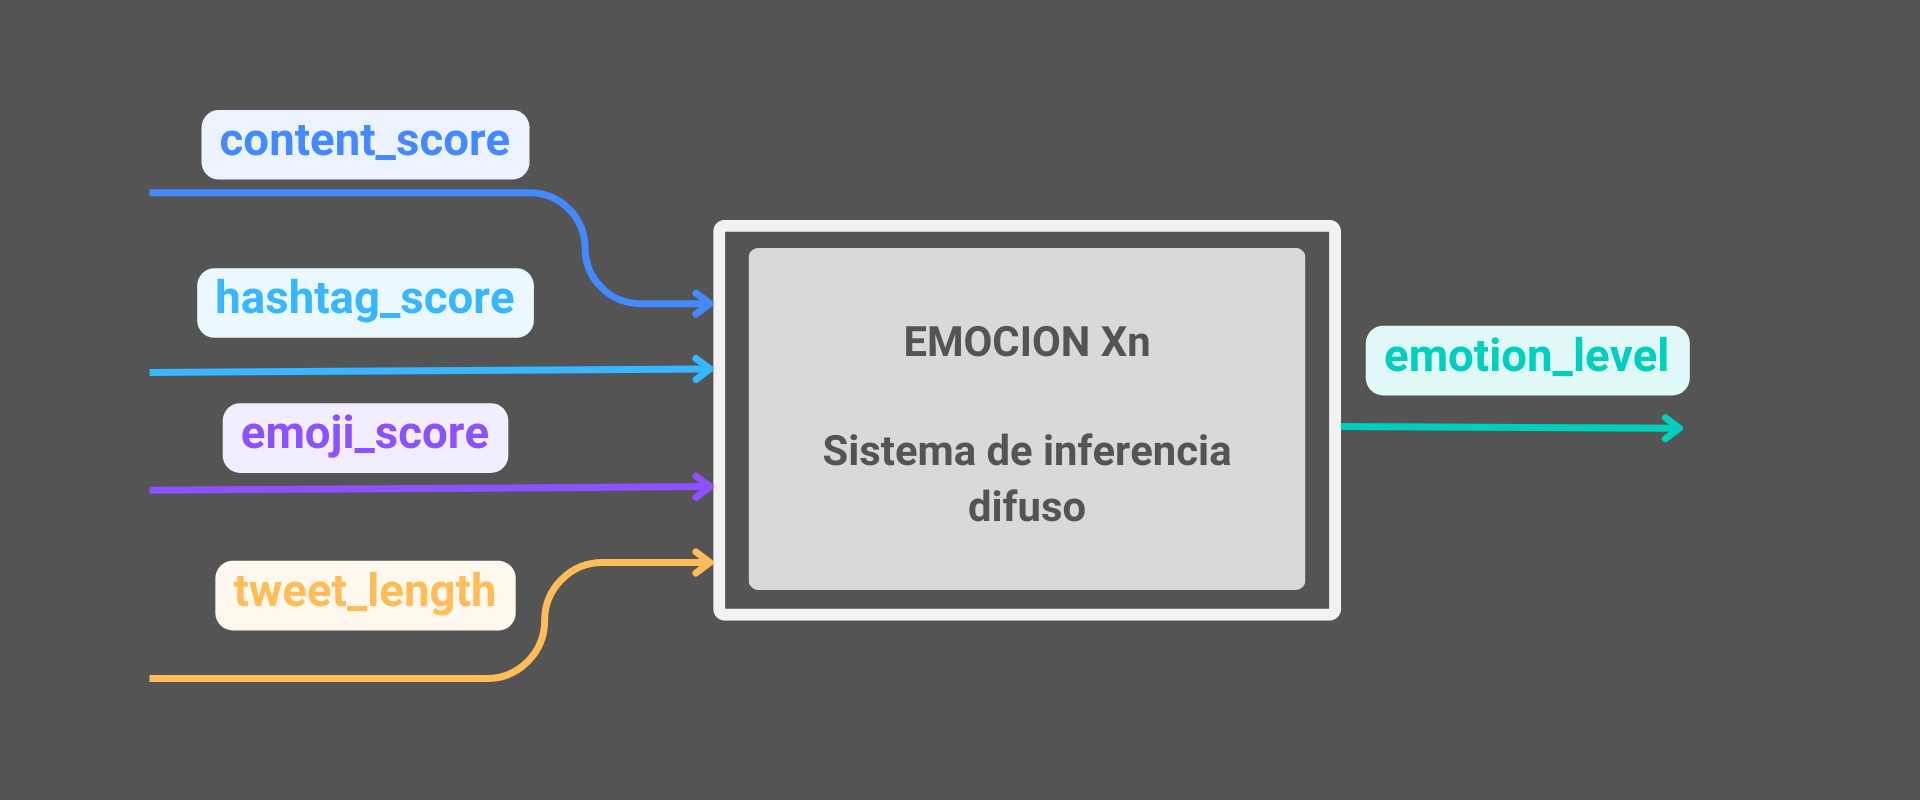

In [128]:
from IPython.display import Image
ruta_imagen = 'diagram_b.png' 
Image(filename=ruta_imagen)

Para ejemplificar el proceso a seguir, trabajaremos con la emocion `Joy` (Alegría). Se debe tener en cuenta que este proceso se replica para las 9 emociones restantes.

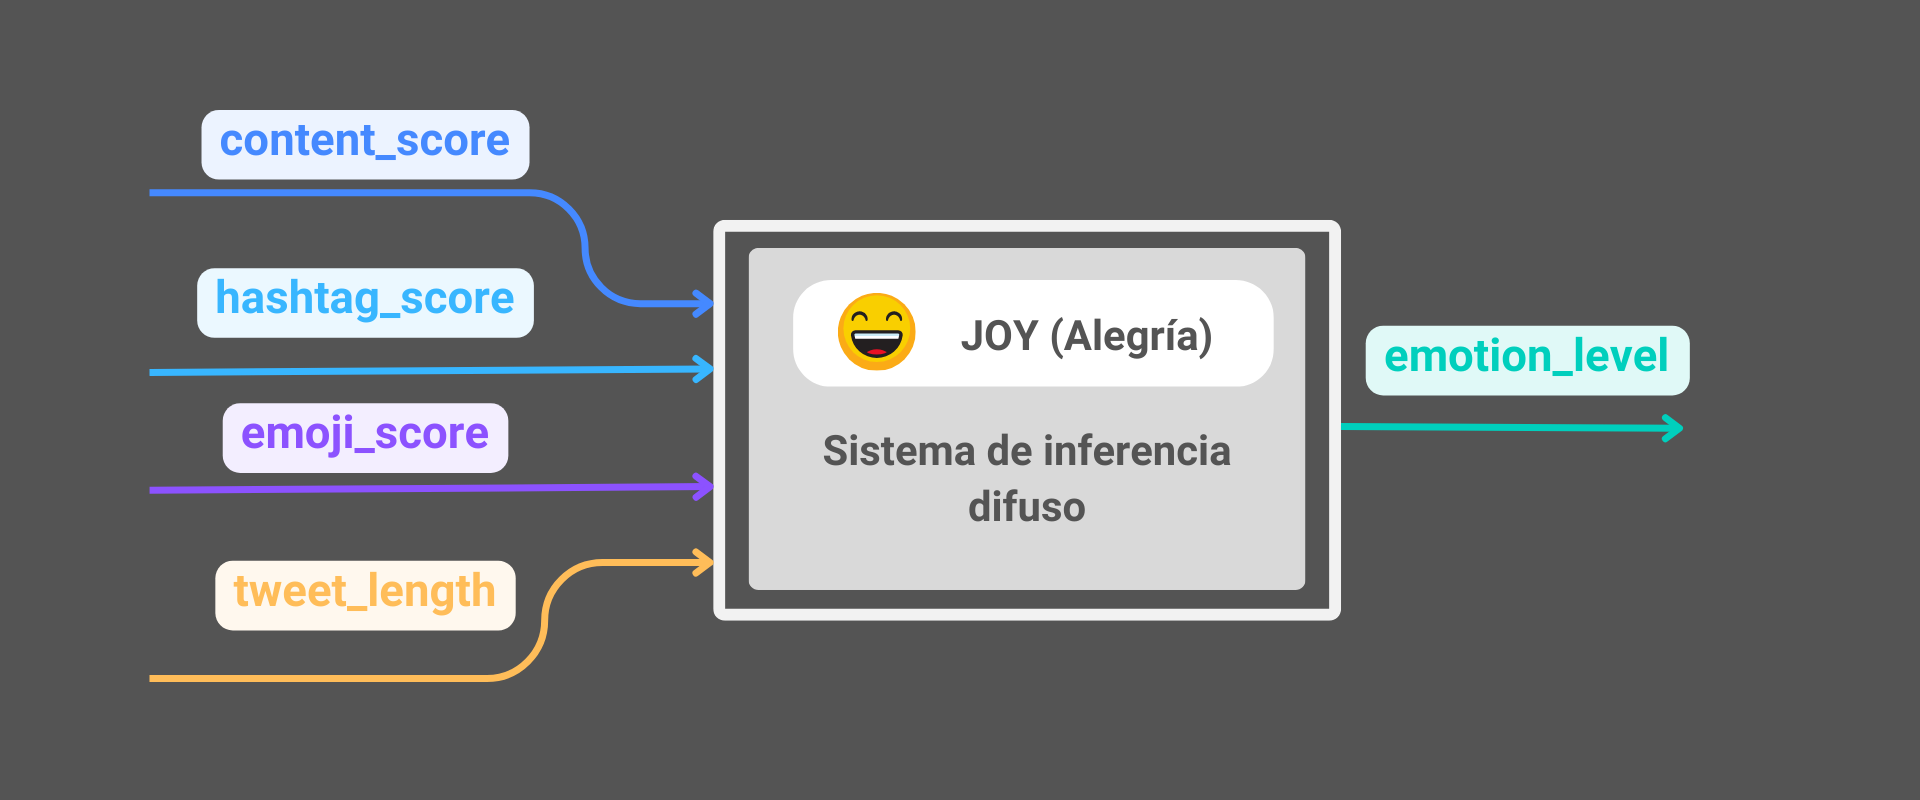

In [129]:
from IPython.display import Image
ruta_imagen = 'diagram_joy.png' 
Image(filename=ruta_imagen)

## 4. Variables de entrada y salida

**VARIABLES DE ENTRADA**
- Puntuacion del contenido `content_score` del Tweet para la emocion `Joy`

- Puntuacion de los hashtags `hashtag_score` del Tweet para la emocion `Joy`

- Puntuacion de los emojis `emoji_score` del Tweet para la emocion `Joy`

- Longitud del tweet `tweet_length`

**VARIABLES DE SALIDA**
- Nivel de intensidad para la emocion `Joy`

## 5. Universo, terminos y funciones

### VARIABLES DE ENTRADA
### content_score
- Universo de discurso: 0-1
- Terminos:
    - Low (bajo) --> 0 - 0.5
    - Medium(medio) --> 0 -1
    - High(alto) --> 0.5 - 1

C:\Users\Nabia\AppData\Roaming\Python\Python311\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


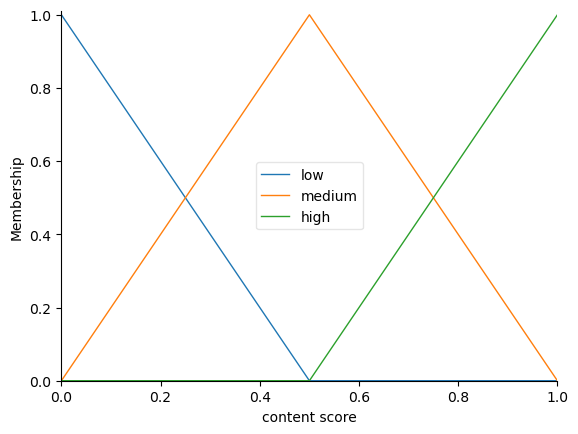

In [130]:
#Definimos el universo discurso
content_score = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'content score')

# Definimos los terminos
content_score["low"] = fuzz.trimf(content_score.universe, [0, 0, 0.5])
content_score["medium"] = fuzz.trimf(content_score.universe, [0, 0.5, 1])
content_score["high"] = fuzz.trimf(content_score.universe, [0.5, 1, 1])

content_score.view()

### hashtag_score
- Universo de discurso: 0-1
- Terminos:
    - Low (bajo) --> 0 - 0.5
    - Medium(medio) --> 0 -1
    - High(alto) --> 0.5 - 1

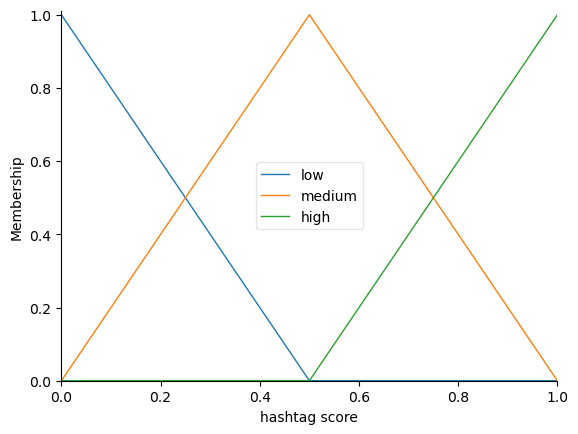

In [131]:
#Definimos el universo discurso
hashtag_score = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'hashtag score')

# Definimos los terminos
hashtag_score["low"] = fuzz.trimf(hashtag_score.universe, [0, 0, 0.5])
hashtag_score["medium"] = fuzz.trimf(hashtag_score.universe, [0, 0.5, 1])
hashtag_score["high"] = fuzz.trimf(hashtag_score.universe, [0.5, 1, 1])

hashtag_score.view()

### emoji_score
- Universo de discurso: 0-1
- Terminos:
    - Low (bajo) --> 0 - 0.5
    - Medium(medio) --> 0 -1
    - High(alto) --> 0.5 - 1

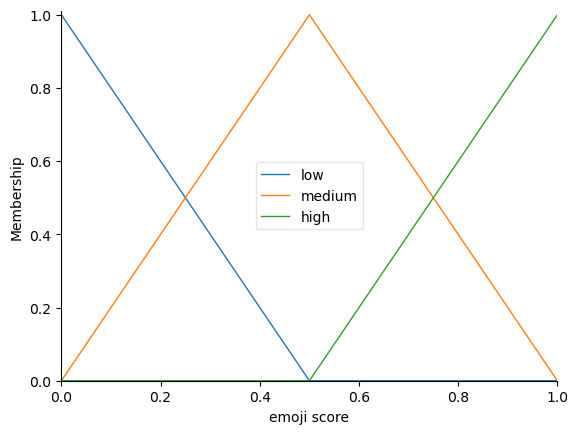

In [132]:
#Definimos el universo discurso
emoji_score = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'emoji score')

# Definimos los terminos
emoji_score["low"] = fuzz.trimf(emoji_score.universe, [0, 0, 0.5])
emoji_score["medium"] = fuzz.trimf(emoji_score.universe, [0, 0.5, 1])
emoji_score["high"] = fuzz.trimf(emoji_score.universe, [0.5, 1, 1])

emoji_score.view()

### tweet_length
- Universo de discurso: 0-140
- Terminos:
    - Low (bajo) --> 0 - 70
    - Medium(medio) --> 0 -140
    - High(alto) --> 70 - 140

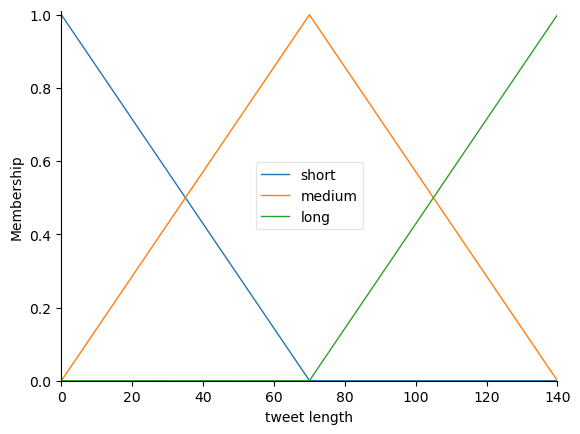

In [133]:
#Definimos el universo discurso
tweet_length = ctrl.Antecedent(np.arange(0, 140.01, 0.01), 'tweet length')

# Definimos los terminos
tweet_length["short"] = fuzz.trimf(tweet_length.universe, [0, 0, 70])
tweet_length["medium"] = fuzz.trimf(tweet_length.universe, [0, 70, 140])
tweet_length["long"] = fuzz.trimf(tweet_length.universe, [70, 140, 140])

tweet_length.view()

### VARIABLE DE SALIDA
### emotion_level
- Universo de discurso: 0-1
- Terminos:
    - Low (bajo) --> 0 - 0.5
    - Medium(medio) --> 0 -1
    - High(alto) --> 0.5 - 1

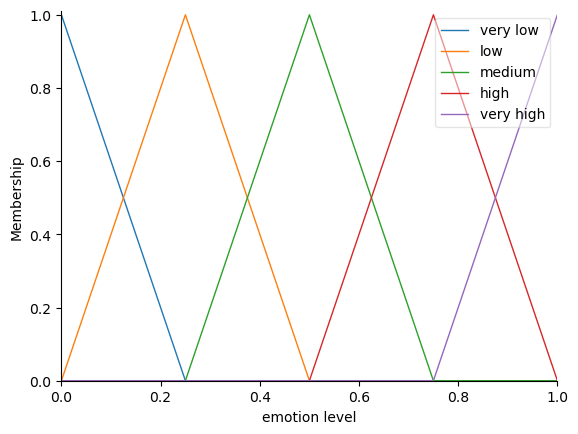

In [134]:
#Definimos el universo discurso
emotion_level = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'emotion level')

# Definimos los terminos
emotion_level["very low"] = fuzz.trimf(emotion_level.universe, [0, 0, 0.25])
emotion_level["low"] = fuzz.trimf(emotion_level.universe, [0, 0.25, 0.5])
emotion_level["medium"] = fuzz.trimf(emotion_level.universe, [0.25, 0.5, 0.75])
emotion_level["high"] = fuzz.trimf(emotion_level.universe, [0.5, 0.75, 1])
emotion_level["very high"] = fuzz.trimf(emotion_level.universe, [0.75, 1, 1])

emotion_level.view()

## 6. Base de reglas

In [135]:
def get_rules(content_score,hashtag_score,emoji_score, tweet_length, emotion_level):
    # Definir las reglas difusas
    r1 =ctrl.Rule(content_score['low']  & hashtag_score['low'] & emoji_score['low'], emotion_level['very low'])
    r2 =ctrl.Rule(content_score['low']  & hashtag_score['low'] & (emoji_score['medium'] | emoji_score['high']), emotion_level['low'])
    r3 =ctrl.Rule(content_score['low']  & hashtag_score['medium'] & emoji_score['low']& tweet_length['short'], emotion_level['very low'])
    r4 =ctrl.Rule(content_score['low']  & hashtag_score['medium'] & emoji_score['low'] & (tweet_length['medium'] | tweet_length['long']), emotion_level['low'])
    r5 =ctrl.Rule(content_score['low']  & hashtag_score['medium'] & (emoji_score['medium'] | emoji_score['high']), emotion_level['medium'])
    r6 =ctrl.Rule(content_score['low']  & hashtag_score['high'] & emoji_score['low'], emotion_level['low'])
    r7 =ctrl.Rule(content_score['low']  & hashtag_score['high'] & emoji_score['medium'], emotion_level['medium'])
    r8 =ctrl.Rule(content_score['low']  & hashtag_score['high'] & emoji_score['high'], emotion_level['high'])
    r9 =ctrl.Rule(content_score['medium']  & hashtag_score['low'] & emoji_score['low'], emotion_level['low'])
    r10 =ctrl.Rule(content_score['medium']  & hashtag_score['low'] & emoji_score['medium'], emotion_level['medium'])
    r11 =ctrl.Rule(content_score['medium']  & hashtag_score['low'] & emoji_score['high'], emotion_level['high'])
    r12 =ctrl.Rule(content_score['medium']  & hashtag_score['medium'] & emoji_score['low'], emotion_level['medium'])
    r13 =ctrl.Rule(content_score['medium']  & hashtag_score['medium'] & (emoji_score['medium'] | emoji_score['high']), emotion_level['high'])
    r14 =ctrl.Rule(content_score['medium']  & hashtag_score['high'] & emoji_score['low'], emotion_level['medium'])
    r15 =ctrl.Rule(content_score['medium']  & hashtag_score['high'] & (emoji_score['medium'] | emoji_score['high']), emotion_level['high'])
    r16 =ctrl.Rule(content_score['high']  & hashtag_score['low'] & emoji_score['low'], emotion_level['medium'])
    r17 =ctrl.Rule(content_score['high']  & hashtag_score['low'] & (emoji_score['medium'] | emoji_score['high']), emotion_level['high'])
    r18 =ctrl.Rule(content_score['high']  & hashtag_score['medium'] & emoji_score['low'], emotion_level['medium'])
    r19 =ctrl.Rule(content_score['high']  & hashtag_score['medium'] & (emoji_score['medium'] | emoji_score['high']), emotion_level['very high'])
    r20 =ctrl.Rule(content_score['high']  & hashtag_score['high'] & emoji_score['low'] & tweet_length['short'], emotion_level['high'])
    r21 =ctrl.Rule(content_score['high']  & hashtag_score['high'] & emoji_score['low']&(tweet_length['medium'] | tweet_length['long']), emotion_level['very high'])
    r22 =ctrl.Rule(content_score['high']  & hashtag_score['high'] & (emoji_score['medium'] | emoji_score['high']), emotion_level['very high'])
    return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15,r16,r17,r18,r19,r20,r21,r22]

## 7. Caso de uso 

In [139]:
# Crear el sistema de control difuso
joy_control = ctrl.ControlSystem(get_rules(content_score,hashtag_score,emoji_score, tweet_length, emotion_level))
joy_machine = ctrl.ControlSystemSimulation(joy_control)

0.8252732709188234


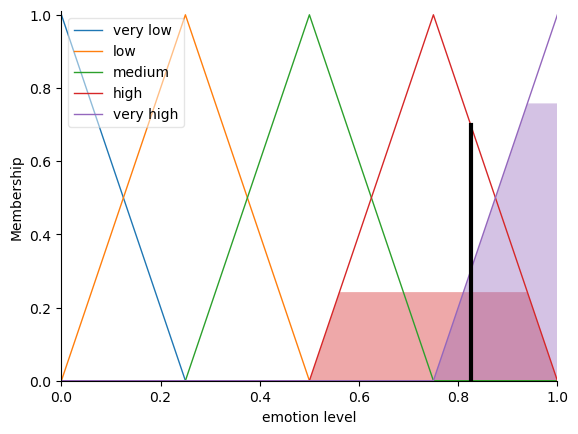

In [140]:
joy = matriz_emociones[9]
# Establecer entradas
joy_machine.input['content score'] = joy[0]
joy_machine.input['hashtag score'] = joy[1]
joy_machine.input['emoji score'] = joy[2]
joy_machine.input['tweet length'] = joy[3]

joy_machine.compute()
print(joy_machine.output['emotion level'])
emotion_level.view(sim=joy_machine)

## 8. Para el resto de emociones

Definimos los universos para las variables de entrada y salida.

In [141]:
content_score = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'content score')
hashtag_score = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'hashtag score')
emoji_score = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'emoji score')
tweet_length = ctrl.Antecedent(np.arange(0, 141, 1), 'tweet length')

Definimos la funcion `get_emotion_machine()` que devuelve un sistema de control difuso para una emocion especifica.

In [146]:
def get_emotion_machine(etiq, content_score, hashtag_score,emoji_score,tweet_length):
    
    labels = ['low', 'medium', 'high']
    for label in labels:
        
        content_score[label] = fuzz.trimf(content_score.universe, [(labels.index(label) - 1)/2 + 0.20, labels.index(label)/2, (labels.index(label) + 1)/2 - 0.20])
        hashtag_score[label] = fuzz.trimf(hashtag_score.universe, [(labels.index(label) - 1)/2 + 0.20, labels.index(label)/2, (labels.index(label) + 1)/2- 0.20])
        emoji_score[label] = fuzz.trimf(emoji_score.universe, [(labels.index(label) - 1)/2 + 0.20, labels.index(label)/2, (labels.index(label) + 1)/2- 0.20])
    
    labels = ['short', 'medium', 'long']
    for label in labels:
        tweet_length[label] = fuzz.trimf(tweet_length.universe, [(labels.index(label) - 1)*70, labels.index(label)*70, (labels.index(label) + 1)*70])
    
    # Variables de salida
    emotion_level = ctrl.Consequent(np.arange(0, 1.01, 0.01), etiq)
    
    labels = ['very low', 'low', 'medium', 'high', 'very high']
    for label in labels:
        emotion_level[label] = fuzz.trimf(emotion_level.universe, [(labels.index(label) - 1)/4, labels.index(label)/4, (labels.index(label) + 1)/4])

    # Sistema de control difuso
    emotion_control = ctrl.ControlSystem(get_rules(content_score,hashtag_score,emoji_score, tweet_length, emotion_level))
    emotion_machine = ctrl.ControlSystemSimulation(emotion_control)
    
    return emotion_machine, emotion_level

Definimos la funcion `compute_emotion()` que calcula el resultado de la inferencia difusa para un caso especifico. 

In [147]:
def compute_emotion(values, etiq, emotion_level,control_machine):
    # Establecer entradas
    control_machine.input['content score'] = values[0]
    control_machine.input['hashtag score'] = values[1]
    control_machine.input['emoji score'] = values[2]
    control_machine.input['tweet length'] = values[3]

    control_machine.compute()
    result = control_machine.output[etiq]
    print()
    print("EMOCION: ", etiq)
    print(result)
    emotion_level.view(sim=control_machine)
    
    return result

In [148]:
def get_result_levels(matriz_emociones,content_score, hashtag_score,emoji_score,tweet_length):
    results = []
    
    for i in range(len(matriz_emociones)):
        machine, emotion_level = get_emotion_machine(emociones[nums_emociones[i]][1],
                                            content_score, hashtag_score,emoji_score,tweet_length)
        result = compute_emotion(matriz_emociones[i],
                                 emociones[nums_emociones[i]][1],emotion_level, machine)
        results.append(result)
    return results


EMOCION:  miedo
0.09840932528369942

EMOCION:  enojo
0.09840932528369942

EMOCION:  Anticipacion
0.39727376624002547

EMOCION:  Confianza
0.7499999999999996

EMOCION:  Sorpresa
0.39727376624002547

EMOCION:  Positivo
0.7500000000000001

EMOCION:  Negativo
0.09840932528369942

EMOCION:  Tristeza
0.09840932528369942

EMOCION:  Asco
0.09840932528369942

EMOCION:  Alegria
0.9069967761590784


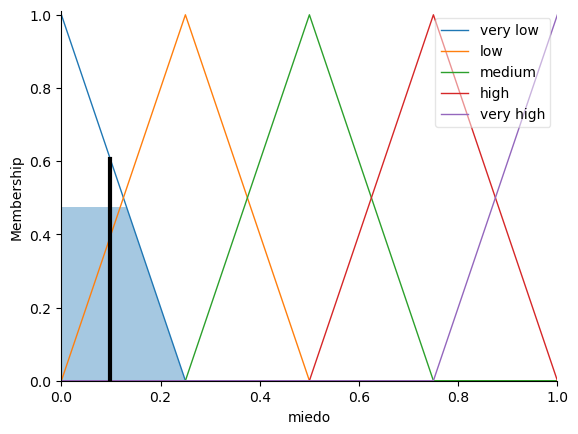

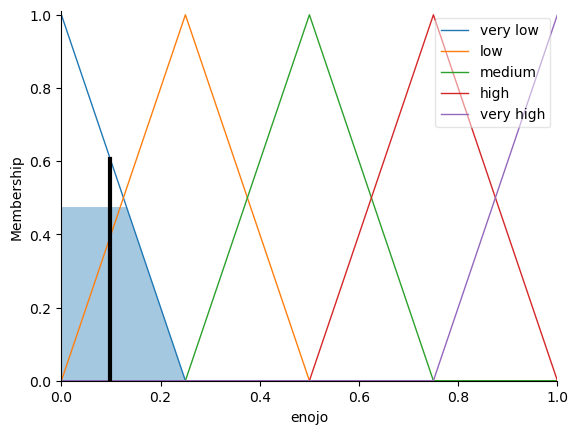

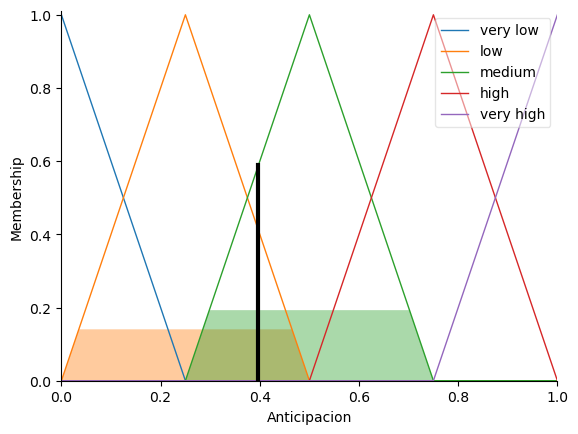

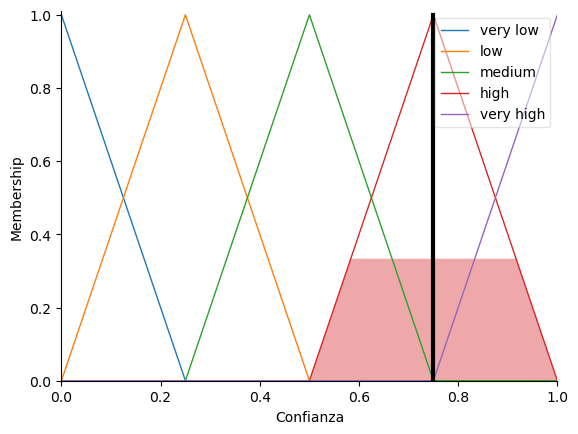

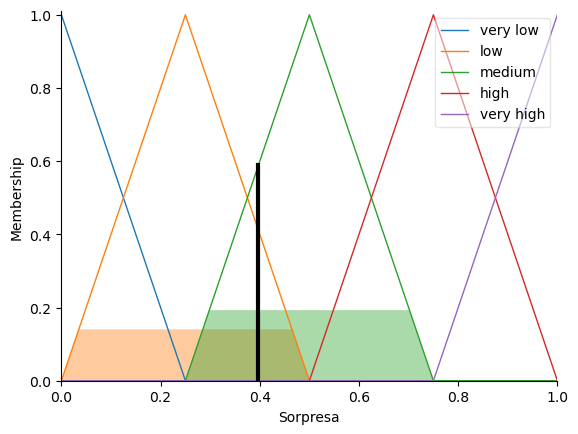

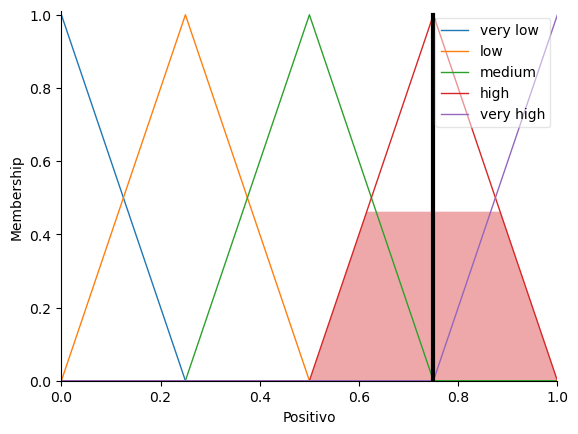

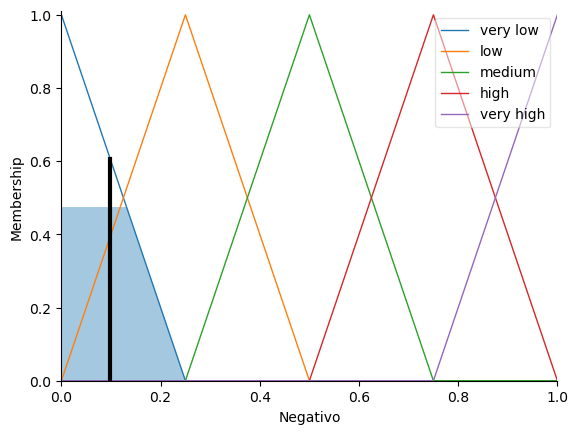

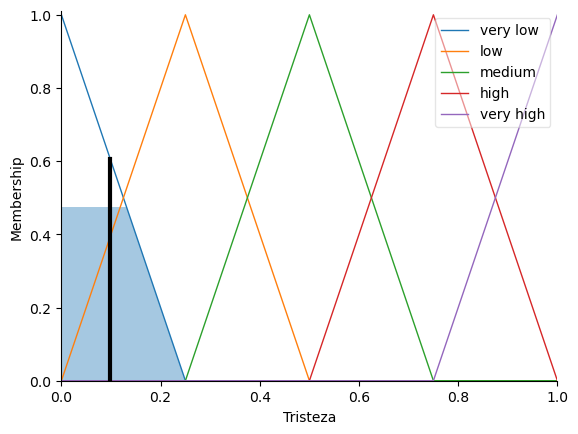

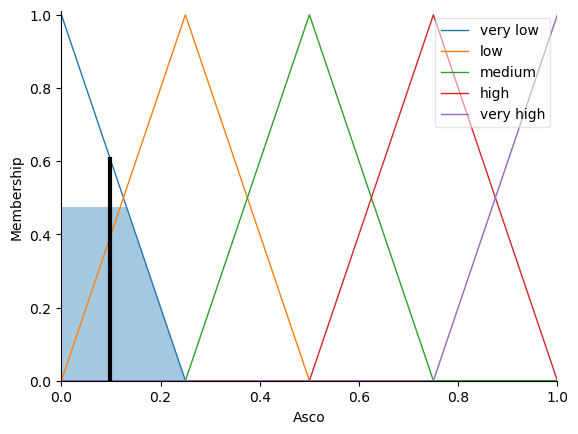

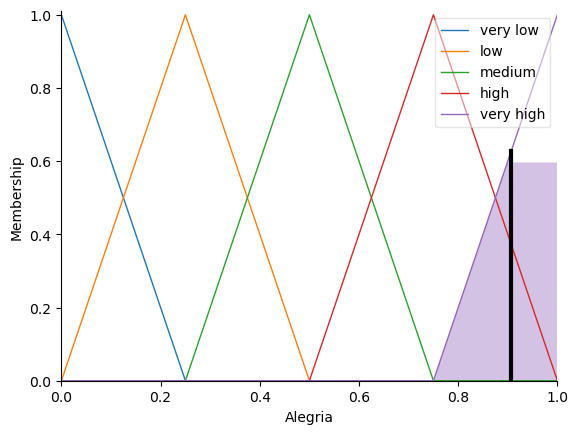

In [149]:
results = get_result_levels(matriz_emociones,content_score, hashtag_score,emoji_score,tweet_length)